<a href="https://colab.research.google.com/github/Haaz123/table_extraction/blob/main/table_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Purpose:**
Detecting table(s) from image and extrating information in processable format.

**USED Models:**  

1.   Layout Parser (Model Zoo) for details: https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html
2.   Google OCR (Google Vision API)



**Pros:**

1.   Can detect Multiple tables from the image(Layout detection)
2.   Good Model for detecting images, text, tables from research papers (Need to change model map and different model from model catalauge) 
3.   GOOGLE OCR can detects text from scanned documents with higher accuracy
**CONS:**

1.   Not very accurate if just table is passed as an image
2.   extracting text with tesseract missed mostly scanned documents text

**How to improve:**

Can collect vetices from google text detection method of different tables and develop a ML method for detected text placement. 











In [2]:
def pip_installs():
  !pip install -U layoutparser
  !pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2' 
  !pip install layoutparser[ocr]
  !git clone https://github.com/Layout-Parser/layout-parser.git
  %cd layout-parser/
  #!sudo apt install tesseract-ocr
  !pip install spacy
  !pip install spacy-transformers
  !python -m spacy download en_core_web_trf
  !pip install click==7.1.1
  #!pip install --upgrade google-cloud-vision

In [3]:
#pip_installs() #Run it first time while running the code once installed comment it out and res-run the runtime

In [4]:
import cv2 
import layoutparser as lp
import spacy
import os
from google.cloud import vision
import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import PIL.Image as Image
import numpy as np


In [5]:
# Load data
img_path = "/content/layout-parser/examples/data/Test14.png" 
image = cv2.imread(img_path)
image = image[..., ::-1] # converting BGR to RGB 

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


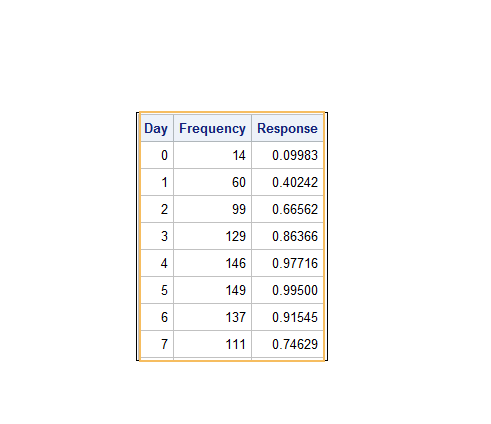

In [6]:
# using the TableBank model to detect n number of tables 
model = lp.Detectron2LayoutModel('lp://TableBank/faster_rcnn_R_101_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
                                 label_map={0: "Table"}) # Model map is given to detect table 
layout = model.detect(image) # once the model is loaded can use different images to detect table
lp.draw_box(image, layout) # draw a box arround detected table(s).

In [7]:

text_blocks = lp.Layout([b for b in layout if b.type=="Table"])
text_blocks


Layout(_blocks=[TextBlock(block=Rectangle(x_1=139.82192993164062, y_1=111.7781982421875, x_2=324.5882873535156, y_2=361.02764892578125), text=None, id=None, type=Table, parent=None, next=None, score=0.9882000684738159)], page_data={})

In [8]:
# store detected numbers of table(s) to n_image list
n_image = []
for block in text_blocks:
    segment_image = (block
                       .pad(left=7, right=7, top=2, bottom=2)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
    n_image.append(segment_image)  
    

In [9]:
#Google API JSON 
#will deactivate the account json after  16-8-2021 
# For more details visit:
#https://cloud.google.com/vision/docs/quickstart-client-libraries
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/layout-parser/examples/text-detection-322411-a1efabf46cf4.json" # Include JSON from your google account

# **GOOGLE VISION** 
As google vision has higher accuracy and is easy to implement

---



In [10]:
cord= []
cord_raw_x= []
cord_raw_y = []
tx = []
def detect_text(path):
    """Detects text in the file."""
    
    client = vision.ImageAnnotatorClient()

    #with io.open(path, 'rb') as image_file:
        #content = image_file.read()
    content = path

    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')
    #print(texts)
    for text in texts:
        print('\n"{}"'.format(text.description))
        tx.append(str(text.description))
        vertices = (['{},{}'.format(vertex.x, vertex.y)
                    for vertex in text.bounding_poly.vertices])
        for vertex in text.bounding_poly.vertices:
          cord.append(int(vertex.x) + int(vertex.y) )
          cord_raw_x.append(vertex.x)
          cord_raw_y.append(vertex.y)
        print('bounds: {}'.format(','.join(vertices)))
        
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['block']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


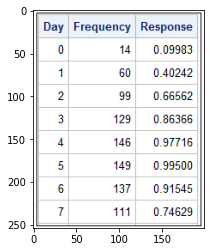

In [11]:
%pylab inline


imgplot = plt.imshow(n_image[0])
plt.show()



**Now lets convert our table to byte to feed in to our google vision API ( Internet is needed)**

In [12]:
img = Image.fromarray(n_image[0], 'RGB')
pil_im = Image.fromarray(n_image[0])
b = io.BytesIO()
pil_im.save(b, 'jpeg')
im_bytes = b.getvalue()
im_bytes




b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\xfe\x00\xc7\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\

In [13]:
detect_text(im_bytes)

Texts:

"Day Frequency Response
14
0.09983
1
60
0.40242
99
0.66562
3
129
0.86366
4
146
0.97716
149
0.99500
6
137
0.91545
7
111
0.74629
2.
"
bounds: 13,14,185,14,185,239,13,239

"Day"
bounds: 13,14,34,14,34,26,13,26

"Frequency"
bounds: 48,14,113,14,113,26,48,26

"Response"
bounds: 126,14,185,14,185,26,126,26

"14"
bounds: 101,40,113,40,113,50,101,50

"0.09983"
bounds: 141,41,184,41,184,50,141,50

"1"
bounds: 31,68,33,68,33,77,31,77

"60"
bounds: 100,68,112,68,112,77,100,77

"0.40242"
bounds: 141,68,184,68,184,78,141,78

"99"
bounds: 101,95,112,95,112,104,101,104

"0.66562"
bounds: 141,95,185,95,185,104,141,104

"3"
bounds: 30,122,34,122,34,131,30,131

"129"
bounds: 95,122,113,122,113,131,95,131

"0.86366"
bounds: 141,122,184,122,184,131,141,131

"4"
bounds: 29,149,34,149,34,158,29,158

"146"
bounds: 94,149,113,149,113,158,94,158

"0.97716"
bounds: 141,149,184,149,184,158,141,158

"149"
bounds: 94,176,112,176,112,185,94,185

"0.99500"
bounds: 141,176,184,176,184,185,141,185

"6"
bounds:

In [17]:
ab = tx[0].split("\n") # text is seperated with "\n"


In [20]:
raw_data= ab[:-1] # do not include last element as it is empty

In [21]:
raw_data

array(['Day Frequency Response', '14', '0.09983', '1', '60', '0.40242',
       '99', '0.66562', '3', '129', '0.86366', '4', '146', '0.97716',
       '149', '0.99500', '6', '137', '0.91545', '7', '111', '0.74629',
       '2.'], dtype='<U22')